## POS tagging using modified Viterbi - Submitted by Tim Kumar M B

### Data Preparation

In [1]:
####Importing required libraries
import nltk
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from collections import Counter
import time

In [2]:
####Reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
class HMM_Base(object):
    '''
    Base class to Model HMM - calculating Transition and Emission Probabilities
    '''
    def __init__(self,dataset,test_size=0.05):
        self.dataset=dataset
        
        self.train_set, self.test_set = train_test_split(self.dataset,test_size=test_size,random_state=10)
        self.train_tagged_words = [word_pos for sent in self.train_set for word_pos in sent]
        self.test_tagged_words = [word_pos[0] for sent in self.test_set for word_pos in sent]
        
        self.V=list(set([word for word,tag in self.train_tagged_words]))
        self.T=list(set(tag for word,tag in self.train_tagged_words))
        self.T.sort()
        
        self.emissions=pd.DataFrame(np.zeros((len(self.T), len(self.V)),dtype='float32'),
                                    index=self.T,columns=self.V)
        self.transitions=pd.DataFrame(np.zeros((len(self.T), len(self.T)),dtype='float32'),
                                      index=self.T,columns=self.T)
        
    def __call__(self):
        self.calculate_emission_prob()
        self.calculate_transition_prob()
        
    def calculate_emission_prob(self):
        '''
        Method to calculate Emission Probabilities
        '''
        lookup={}
        for word,pos in self.train_tagged_words:
            if pos not in lookup.keys():
                lookup[pos]=[word]     
            else:
                lookup[pos].append(word)

        for pos in lookup:
            word_counter=Counter(lookup[pos])
            for word in word_counter:
                self.emissions.loc[pos,word] = word_counter[word]/len(lookup[pos])
    
    def calculate_transition_prob(self):
        '''
        Method to calculate Emission Probabilities
        '''
        lookup_tags={}
        for index,(word,pos) in enumerate(self.train_tagged_words):
            if pos not in lookup_tags.keys():
                lookup_tags[pos]=[self.train_tagged_words[index+1][1]]    
            else:
                if index < len(self.train_tagged_words)-1:
                    lookup_tags[pos].append(self.train_tagged_words[index+1][1])

        
        for pos in lookup_tags:
            tags_counter=Counter(lookup_tags[pos])
            for tag in tags_counter:
                self.transitions.loc[pos,tag] = tags_counter[tag]/len(lookup_tags[pos])
                
    @staticmethod
    def check_accuracy(test_set,tagged_seq):
        test_base = [word_pos for sent in test_set for word_pos in sent]
        check = [i for i, j in zip(tagged_seq, test_base) if i == j] 
        accuracy = len(check)/len(tagged_seq)
        return accuracy
    
    def most_common_tag(self):
        return Counter([tag for word,tag in self.train_tagged_words]).most_common(1)[0][0]

In [4]:
####Creating HMM object, initializing required variables and calculating required probabilities
base_HMM=HMM_Base(nltk_data)
base_HMM()

In [5]:
####Tags available in the selected dataset
base_HMM.T

['.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X']

In [6]:
####Transition Probabilities 
base_HMM.transitions

,.,ADJ,ADP,ADV,CONJ,DET,NOUN,NUM,PRON,PRT,VERB,X
.,0.093691,0.045080,0.090794,0.054223,0.058115,0.172898,0.217797,0.081651,0.066624,0.002444,0.088983,0.027700
ADJ,0.064029,0.066820,0.078148,0.004761,0.017403,0.004597,0.699393,0.020850,0.000493,0.010671,0.011821,0.021015
ADP,0.039484,0.106712,0.016647,0.013446,0.000854,0.325045,0.320990,0.063280,0.068829,0.001281,0.008537,0.034895
ADV,0.137027,0.128733,0.120770,0.078301,0.007299,0.066689,0.031520,0.032847,0.014930,0.014599,0.345720,0.021566
CONJ,0.035914,0.113340,0.053172,0.055037,0.000466,0.121735,0.350746,0.041511,0.059701,0.004664,0.155317,0.008396
DET,0.017377,0.206951,0.009050,0.012188,0.000483,0.005430,0.637867,0.021841,0.003258,0.000241,0.039218,0.046096
NOUN,0.238470,0.012152,0.177928,0.016947,0.042643,0.013360,0.263653,0.009810,0.004795,0.044546,0.146889,0.028807
NUM,0.118101,0.032938,0.035608,0.003264,0.013650,0.003264,0.355193,0.184866,0.001187,0.025816,0.017804,0.208309
PRON,0.039171,0.073733,0.023041,0.034562,0.005376,0.009985,0.209293,0.006912,0.007680,0.012289,0.485407,0.092550
PRT,0.042428,0.086162,0.021214,0.010444,0.001958,0.101501,0.249674,0.054830,0.017624,0.001958,0.399478,0.012728


In [7]:
####Checking if the probabilities sum upto to 1 
print(base_HMM.transitions.sum(axis=1))
print("-----------------------------------")
print(base_HMM.emissions.sum(axis=1))

.       1.0
ADJ     1.0
ADP     1.0
ADV     1.0
CONJ    1.0
DET     1.0
NOUN    1.0
NUM     1.0
PRON    1.0
PRT     1.0
VERB    1.0
X       1.0
dtype: float32
-----------------------------------
.       1.0
ADJ     1.0
ADP     1.0
ADV     1.0
CONJ    1.0
DET     1.0
NOUN    1.0
NUM     1.0
PRON    1.0
PRT     1.0
VERB    1.0
X       1.0
dtype: float32


In [8]:
####Provided Test cases
test_cases=[
"Android is a mobile operating system developed by Google.",
"Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.",
"Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
"Twitter is an online news and social networking service on which users post and interact with messages known as tweets.",
"Before entering politics, Donald Trump was a domineering businessman and a television personality.",
"The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.",
"This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.",
"Show me the cheapest round trips from Dallas to Atlanta",
"I would like to see flights from Denver to Philadelphia.",
"Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.",
"NASA invited social media users to experience the launch of ICESAT-2 Satellite."
]

### Build the vanilla Viterbi based POS tagger

In [9]:
class HMM_Viterbi(HMM_Base):
    '''
    Plain vanilla Viterbi Heuristic for POS Tagging
    '''
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        
    
    ####Plain Vanilla Viterbi Heuristic
    def viterbi(self,words,test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    emission_p = self.emissions.loc[tag,word] 
                    state_probability = emission_p * transition_p    
                    p.append(state_probability)
            else:
                p=[0] #### if the word is unknown 
                unknown_words.append(word)

            pmax = max(p)
            state_max = self.T[p.index(pmax)] 
            state.append(state_max)
        
        if test_case:
            print("Unknown Words---->", unknown_words)
        return list(zip(words, state))


In [10]:
####Creating object of "HMM_Viterbi" class and perfoming the base setup
viterbi_base=HMM_Viterbi(nltk_data)
viterbi_base()

In [11]:
####Checking accuracy of the model
start = time.time()
tagged_seq=viterbi_base.viterbi(viterbi_base.test_tagged_words)
accuracy=viterbi_base.check_accuracy(viterbi_base.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.894576012223071
Time taken in seconds:  7.647622108459473


In [12]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_base.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', '.'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', '.'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', '.'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', '.'), ('worldwide', '.'), ('on', 'ADP'), ('smartphones', '.'), ('since', 'ADP'), ('2011', '.'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', '.'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', '.'), ('and', 'CONJ'), ('Twitter', '.'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', '.'), ('that', 'DET'), ('gave', 'VERB'), ('Google', '.'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', '.'), ("'s", 'VERB'), ('firehose', '.'), ('.', '.')]
Unknown Words----> ['Twitter', 'onlin

##### Observations: Accuracy of the model is 89.45% . For the unknown words, the first tag from the list of tags (T variable) is returned 
##### Lets solve the problem of unknown words using Lexicon , probabilistic and rule based approches

### Solve the problem of unknown words

### 1. Lexicon Based

In [13]:
class HMM_Viterbi_Lexicon(HMM_Base):
    '''
    Tagging unkown words using Lexicons - unigram, bigram & trigram tagger with default set 
    to the most common tag available in the dataset
    '''
    
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        self.tagger_default = nltk.DefaultTagger(self.most_common_tag())
        self.unigram_tagger = nltk.UnigramTagger(self.train_set,backoff=self.tagger_default)
        self.bigram_tagger  = nltk.BigramTagger(self.train_set,backoff=self.unigram_tagger)
        self.trigram_tagger = nltk.TrigramTagger(self.train_set,backoff=self.bigram_tagger)
        
  
    def find_tag(self,word):
        return self.trigram_tagger.tag([word])[0][1]

    ####Overriding base viterbi implementation to take care of unknown words    
    def viterbi(self,words,test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    emission_p = self.emissions.loc[tag,word]
                    state_probability = emission_p * transition_p    
                    p.append(state_probability)

                pmax = max(p)
                state_max = self.T[p.index(pmax)] 
                state.append(state_max)
            
            else:
                unknown_words.append(word)
                word_state=self.find_tag(word)
                state.append(word_state)
        
        if test_case:
            print("Unknown Words---->", unknown_words)        
        return list(zip(words, state))

In [14]:
####Creating object of "HMM_Viterbi_Lexicon" class and perfoming the base setup
viterbi_lexicon=HMM_Viterbi_Lexicon(nltk_data)
viterbi_lexicon()

In [15]:
####Checking accuracy of the model
start = time.time()
tagged_seq=viterbi_lexicon.viterbi(viterbi_lexicon.test_tagged_words)
accuracy=viterbi_lexicon.check_accuracy(viterbi_lexicon.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.9409854851031322
Time taken in seconds:  6.754146337509155


In [16]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_lexicon.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.

##### Observations: Accuracy of the Lexicon model is improved to 94%. However on further analysis, its clear that almost all unknown words have been tagged as 'NOUN'

### 2.1 Probablistic - Considering previous 2 tags

##### Unknown words are tagged based on the highest probable tag given the previous 2 tags

In [17]:
class HMM_Viterbi_Prob_2_tags(HMM_Base):
    '''
    Tagging unkown words considering previous 2 tags
    '''
    
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        self.before_2_tags={}
        self.default_tag=self.most_common_tag()
        
        
    def __call__(self):
        super().__call__()
        self.check_before_2_tags()      
    
    ####Dict holding previous 2 tags as key and current tag as value
    def check_before_2_tags(self):
        for sent in self.train_set:
            for index, (word, pos) in enumerate(sent):
                if (len(sent)>2) and (index>1) and (index<len(sent)):
                    prev_prev_tag=sent[index-2][1]
                    prev_tag=sent[index-1][1]
                    if (prev_prev_tag,prev_tag) not in self.before_2_tags :
                        self.before_2_tags[(prev_prev_tag,prev_tag)]=[pos]              
                    else:
                        self.before_2_tags[(prev_prev_tag,prev_tag)].append(pos)
    
    ####Returns most likely tag given previous 2 tags
    def get_tag_likely(self,before_tags):
        if before_tags in self.before_2_tags:
            return Counter(self.before_2_tags[before_tags]).most_common(1)[0][0]
        else:
            return self.default_tag
    
    ####Overriding base viterbi implementation to take care of unknown words  
    def viterbi(self,words,test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    emission_p = self.emissions.loc[tag,word]
                    state_probability = emission_p * transition_p    
                    p.append(state_probability)

                pmax = max(p)
                state_max = self.T[p.index(pmax)] 
                state.append(state_max)
            
            else:
                unknown_words.append(word)
                if key>1 and (words[key-1] in self.V )and (words[key-2] in self.V) and (key<len(words)):
                    prev_tag=state[-1]
                    next_tag=state[-2]
                    #print(word,prev_tag,next_tag)
                    word_state=self.get_tag_likely((prev_tag,next_tag))
                
                else:   
                    word_state=self.default_tag

                state.append(word_state)
        
        if test_case:
            print("Unknown Words---->", unknown_words)
        return list(zip(words, state))

In [18]:
####Creating object of "HMM_Viterbi_Prob_2_tags" class and perfoming the base setup
viterbi_probabilistic_2tags=HMM_Viterbi_Prob_2_tags(nltk_data)
viterbi_probabilistic_2tags()

In [19]:
####Checking accuracy of the model
start = time.time()
tagged_seq=viterbi_probabilistic_2tags.viterbi(viterbi_probabilistic_2tags.test_tagged_words)
accuracy=viterbi_probabilistic_2tags.check_accuracy(viterbi_probabilistic_2tags.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.9323911382734912
Time taken in seconds:  8.159297227859497


In [20]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_probabilistic_2tags.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'

##### Observations: Accuracy of the model is 93.23%. Though this approach doesn't default to "NOUN" on almost all cases, accuracy is pretty lower 

### 2.2 Probablistic - Considering previous tag

##### Unknown words are tagged based on the highest probable tag given the previous tag

In [21]:
class HMM_Viterbi_Prob_1_tag(HMM_Base):
    '''
    Tagging unkown words considering previous tag
    '''
    
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        self.prev_tag={}
        self.default_tag=self.most_common_tag()       
        
    def __call__(self):
        super().__call__()
        self.previous_tag()      
     
    ####Creating a lookup based on trainset equivalent mapping of {(prev_tag):current_tag}
    def previous_tag(self):
        for sent in self.train_set:
            for index, (word, pos) in enumerate(sent):
                if (len(sent)>1) and (index>0) and (index<len(sent)):
                    tag_before=sent[index-1][1]
                    if tag_before not in self.prev_tag :
                        self.prev_tag[tag_before]=[pos]              
                    else:
                        self.prev_tag[tag_before].append(pos)

    ####Returns most likely tag given previous tag
    def get_tag_likely(self,before_tag):
        if before_tag in self.prev_tag:
            return Counter(self.prev_tag[before_tag]).most_common(1)[0][0]
        else:
            return self.default_tag
    
    ####Overriding base viterbi implementation to take care of unknown words
    def viterbi(self,words,test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    emission_p = self.emissions.loc[tag,word]
                    state_probability = emission_p * transition_p    
                    p.append(state_probability)

                pmax = max(p)
                state_max = self.T[p.index(pmax)] 
                state.append(state_max)
            
            else:
                unknown_words.append(word)
                if key>0 and (words[key-1] in self.V ) and (key<len(words)):
                    before_tag=state[-1]
                    #print(word,prev_tag)
                    word_state=self.get_tag_likely(before_tag)
                
                else:   
                    word_state=self.default_tag

                state.append(word_state)
        
        if test_case:
            print("Unknown Words---->", unknown_words)
        return list(zip(words, state))

In [22]:
viterbi_probabilistic_1tag=HMM_Viterbi_Prob_1_tag(nltk_data)
viterbi_probabilistic_1tag()

In [23]:
####Checking accuracy of the model
start = time.time()
tagged_seq=viterbi_probabilistic_1tag.viterbi(viterbi_probabilistic_1tag.test_tagged_words)
accuracy=viterbi_probabilistic_1tag.check_accuracy(viterbi_probabilistic_1tag.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.9415584415584416
Time taken in seconds:  5.702728748321533


In [24]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_probabilistic_1tag.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'DET'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'DET'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'DET'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'VERB'), ('.', '.')]
Unkn

##### Observations: Accuracy of the model is 94.15%. However it doesnt do well on test cases

### 2.3 Probablistic - Considering previous and next tag

##### Unknown words are tagged based on the highest probable tag given the previous tag and the next tag. The next tag is found using the Bayes Rule - P(Tag|Word) = P(Word|Tag) * P(Tag) and we can obtain P(Word|Tag)  from Emission Probability table

In [25]:
class HMM_Viterbi_Modified_Prob(HMM_Base):
    '''
    Tagging unkown words considering previous tag and the next tag(found using Bayes Rule)
    '''
    
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        self.lookup_before_n_after_tag={}
        self.default_tag=self.most_common_tag()     
        
    def __call__(self):
        super().__call__()
        self.check_before_after_tags()
        self.prob_of_tags=self.find_prob_of_tags()
    
    ####Finding probability of 12 tags
    def find_prob_of_tags(self):
        list_tags=[pos for word,pos in self.train_tagged_words]
        tag_prob={key:Counter(list_tags)[key]/len(list_tags) for key in Counter(list_tags)}
        return (pd.Series(tag_prob,index=self.T))
    
    ####Creating a lookup based on trainset equivalent mapping of {(prev_tag,next_tag):current_tag}
    def check_before_after_tags(self):
        for sent in self.train_set:
            for index, (word, pos) in enumerate(sent):
                if len(sent)>1:
                    if index == 0 :
                        if (None,sent[index+1][1]) not in self.lookup_before_n_after_tag :
                            self.lookup_before_n_after_tag[(None,sent[index+1][1])]=[pos]              
                        else:
                            self.lookup_before_n_after_tag[(None,sent[index+1][1])].append(pos)
               
                    elif index == len(sent)-1:
                        if (sent[index-1][1],None) not in self.lookup_before_n_after_tag:
                            self.lookup_before_n_after_tag[(sent[index-1][1],None)]=[pos]
                        else:
                            self.lookup_before_n_after_tag[(sent[index-1][1],None)].append(pos)
                
                    else:
                        if (sent[index-1][1],sent[index+1][1]) not in self.lookup_before_n_after_tag:
                            self.lookup_before_n_after_tag[(sent[index-1][1],sent[index+1][1])]= [pos]
                        else:
                            self.lookup_before_n_after_tag[(sent[index-1][1],sent[index+1][1])].append(pos)
    
    ####Returns most likely tag given previous tag and next tag
    def get_tag_likely(self,before_after_tag):
        if before_after_tag in self.lookup_before_n_after_tag:
            return Counter(self.lookup_before_n_after_tag[before_after_tag]).most_common(1)[0][0]
        else:
            return self.default_tag
    
    ####Overriding base viterbi implementation to take care of unknown words
    def viterbi(self,words,test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    emission_p = self.emissions.loc[tag,word]
                    state_probability = emission_p * transition_p    
                    p.append(state_probability)

                pmax = max(p)
                state_max = self.T[p.index(pmax)] 
                state.append(state_max)
            
            else:
                unknown_words.append(word)
                if key==0 and words[key+1] in self.V:
                    prev_tag=None
                    next_tag=(self.emissions[words[key+1]]*self.prob_of_tags).idxmax()
                    prev_tag_available, next_tag_available=1,1
                elif key==len(words)-1 and words[key-1] in self.V:
                    prev_tag=(self.emissions[words[key-1]]*self.prob_of_tags).idxmax()
                    next_tag=None
                    prev_tag_available, next_tag_available=1,1
                elif words[key-1] in self.V and words[key+1] in self.V: 
                    prev_tag=(self.emissions[words[key-1]]*self.prob_of_tags).idxmax()
                    next_tag=(self.emissions[words[key+1]]*self.prob_of_tags).idxmax()
                    prev_tag_available, next_tag_available=1,1
                else: 
                    prev_tag_available, next_tag_available=0,0
                    word_state=self.default_tag

                if prev_tag_available ==1 and next_tag_available ==1:
                    word_state=self.get_tag_likely((prev_tag,next_tag))
                    #print(word, prev_tag,next_tag,word_state)
                
                state.append(word_state)
            
        if test_case:
            print("Unknown Words---->", unknown_words)
        return list(zip(words, state))

In [26]:
viterbi_modified_prob=HMM_Viterbi_Modified_Prob(nltk_data)
viterbi_modified_prob()

In [27]:
start = time.time()
tagged_seq=viterbi_modified_prob.viterbi(viterbi_modified_prob.test_tagged_words)
accuracy=viterbi_modified_prob.check_accuracy(viterbi_modified_prob.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.9423223834988541
Time taken in seconds:  8.378200769424438


In [28]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_modified_prob.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NOUN'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NOUN'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'DET'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.'

##### Observations: Accuracy of the model is 94.23% . Model is able to predict most NOUN tags correctly without being defaulted to and also other tags as well for words such as 11th , domineering etc

### 3. Rule Based

In [29]:
class HMM_Viterbi_RuleBased(HMM_Base):
    
    patterns=[(r'\w+-\w+', 'ADJ'),             
              (r'.*(ed|en|ate|fy|ing)$', 'VERB'), 
              (r'.*(ly|lly)$', 'ADV'),
              (r'.*(ic|able|ible|ous|ical|ive|hy|ial|ful|ist)$', 'ADJ'),
              (r'.*(\'s|ies)$', 'NOUN'),              
              (r'.*(ment|ness|ism|ion|ship|hood|age)$', 'NOUN'), 
              (r'(\*)+(.)*', 'X'),
              (r'[0-9]+(st|nd|rd|th)$', 'ADJ'), 
              (r'^-?[0-9]+([,0-9]+)*(.[0-9]+)?(st|nd|rd|th)?$', 'NUM'), 
              (r'.*', 'NOUN')                    
             ]
    regexp_tagger = nltk.RegexpTagger(patterns)
    
    def __init__(self,nltk_data):
        super().__init__(nltk_data)
        
    @classmethod    
    def find_tag(cls,word):
        return cls.regexp_tagger.tag([word])[0][1]

        
    def viterbi(self, words, test_case=False):
        state = []
        unknown_words=[]
        for key, word in enumerate(words):
            #initialise list of probability column for a given observation
            p = []
            if word in self.V:
                for tag in self.T:
                    if key == 0:
                        transition_p = self.transitions.loc['.', tag]
                    else:
                        transition_p = self.transitions.loc[state[-1], tag]
                
                    # compute emission and state probabilities
                    emission_p = self.emissions.loc[tag,word]

                    state_probability = emission_p * transition_p    
                    p.append(state_probability)

                pmax = max(p)

                # getting state for which probability is maximum
                state_max = self.T[p.index(pmax)] 
                state.append(state_max)
            
            else:
                unknown_words.append(word)
                word_state=self.find_tag(word)
                state.append(word_state)
            
        if test_case:
            print("Unknown Words---->", unknown_words)
        return list(zip(words, state))
    

In [30]:
viterbi_rule_based=HMM_Viterbi_RuleBased(nltk_data)
viterbi_rule_based()

In [31]:
####Checking accuracy of the model
start = time.time()
tagged_seq=viterbi_rule_based.viterbi(viterbi_rule_based.test_tagged_words)
accuracy=viterbi_rule_based.check_accuracy(viterbi_rule_based.test_set,tagged_seq)
print("Accuracy of HMM: ", accuracy)
print("Time taken in seconds: ", time.time()-start)

Accuracy of HMM:  0.9618029029793735
Time taken in seconds:  6.627201557159424


In [32]:
####Evaluating Test Cases
for sentence_test in test_cases:
    words = word_tokenize(sentence_test)
    tagged_seq = viterbi_rule_based.viterbi(words,test_case=True)
    print(tagged_seq)
    print("====================================================================================================")

Unknown Words----> ['Android', 'Google']
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]
Unknown Words----> ['Android', 'OS', 'worldwide', 'smartphones', '2011', '2013']
[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]
Unknown Words----> ['Google', 'Twitter', '2015', 'Google', 'Twitter', 'firehose']
[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]

##### Observations: Accuracy of the model is 96.18% . Model is able to predict most of the tags correctly

### Evaluating Test Set

In [33]:
####Helper Fn to evaulate test data.
def evaluate_accuracy(path='Test_sentences.txt',model=viterbi_rule_based):
    '''
    Available model objects - viterbi_base,viterbi_lexicon,viterbi_probabilistic_2tags,
    viterbi_probabilistic_1tag,viterbi_modified_prob,viterbi_rule_based
    '''
    with open(path) as f:
        for sentence_test in f:
            words = word_tokenize(sentence_test)
            tagged_seq = model.viterbi(words,test_case=True)
            print(tagged_seq)
            print("====================================================================================================") 

In [34]:
#Provide path and model var to evaluate 
#evaluate_accuracy(path='Test_sentences.txt',model=viterbi_rule_based)

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

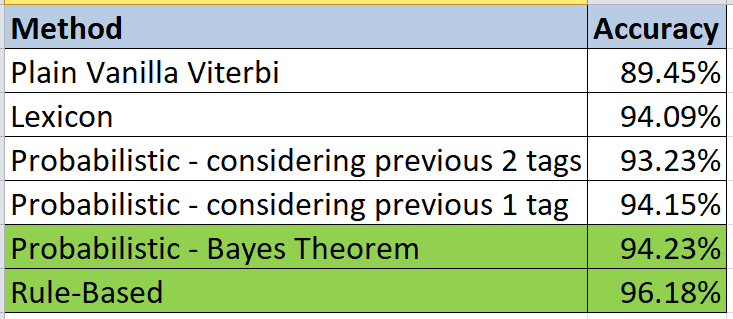

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

##### Probabilistic model using Bayes Theorem and Rule Based Model perform better

##### Following unknown words have been correctly identified by Probabilistic model which were incorrecty tagged by Original POS tagger - 'Android','Google','smartphones', 'Twitter', 'firehose','tweets','domineering ','personality', 'Cup',  'Cup', '11th','trips','Denver','NASA','Satellite'

##### Following unknown words have been correctly identified by Rule Based model which were incorrecty tagged by Original POS tagger - 'Android','Google','OS', 'worldwide', 'smartphones', '2011', '2013','2015', 'Google', 'Twitter', 'firehose','messages', 'tweets','personality','2018', '21st', 'FIFA', 'Cup', 'tournament', 'contested','Cup', '11th','trips','Denver','NASA', 'invited', 'ICESAT-2', 'Satellite'